# Alzheimer's Disease classification from anatomical MRI

### This notebook explores the use of a low-dimensional feature space to classify Alzheimer's disease from anatomical MRI images.

Briefly, the pipeline involves the following steps and technical features:

- Data formating and quality check
- Custom CNN for classification
- Hyperparameter tuning
- Final model application
<!-- - Transfer learning using ResNet50  -->

### Import analysis and plotting libraries

In [55]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import pyspark
from pyspark.sql import SparkSession
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import plot_model
import keras_tuner as 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import false_discovery_control

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

In [ ]:
# import pyspark module
spark = SparkSession.builder.appName("Brad's PySpark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

### Load and format training data

In [2]:
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


#### Convert data to readable format

In [3]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and format test data

In [4]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

### Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

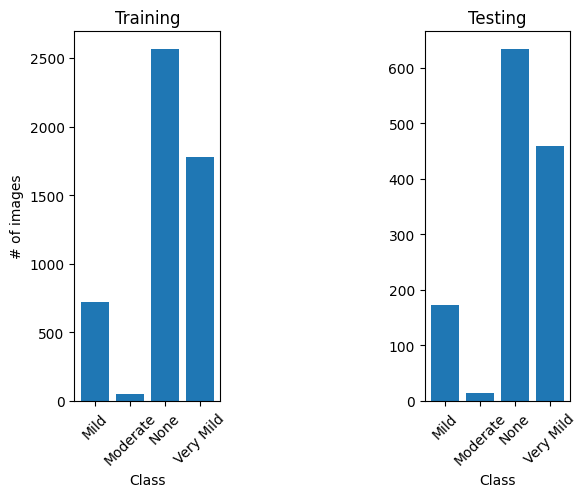

In [5]:
f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

## Visually inspect data

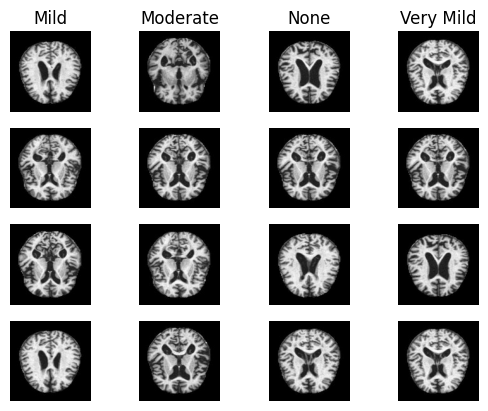

In [8]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

## First, build a very basic custom CNN for classification

### Format images (stored in local memory)

In [13]:
# training data
train_data = np.empty((len(train), 128, 128))
for i in range(len(train)):
   train_data[i, :, :] = train.iloc[i].img_arr

# test data
test_data = np.empty((len(test), 128, 128))
for i in range(len(test)):
   test_data[i, :, :] = test.iloc[i].img_arr

# format in 3D shape that keras likes
train_data = np.expand_dims(train_data, axis = 3)
test_data = np.expand_dims(test_data, axis = 3)
train_data.shape

(5120, 128, 128, 1)

### Data augmentation

In [15]:
# Resize and rescale functions
IMG_SIZE = 128
resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment =False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls = AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y),
                num_parallel_calls = AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size = AUTOTUNE)

### Augment training dataset only

#### Verify augmentation on first image

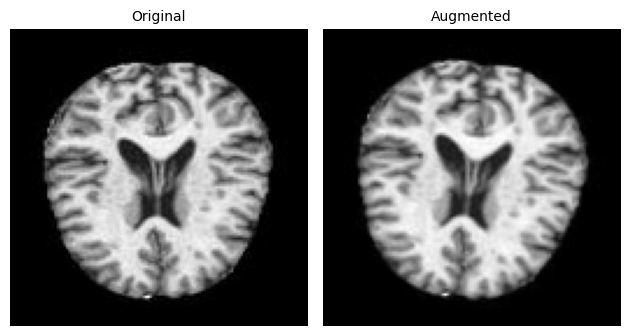

In [17]:
# sample dataset
train_data_tmp = train_data[0]
train_data_tmp = np.expand_dims(train_data_tmp, axis = 0)

# apply augmentation
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tmp, train_lab_idx[:1]))
train_ds = prepare(train_ds, shuffle=True, augment=True)

# view augmented images
train_ds = train_ds.unbatch()
images = np.asarray(list(train_ds.map(lambda x, y: x)))

f, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[0].imshow(train_data[0], cmap = "gray",)
ax[0].set_title('Original', fontsize = 10)

ax[1].axis('off')
ax[1].imshow(images[0,:,:,:], cmap = "gray",)
ax[1].set_title('Augmented', fontsize = 10)
plt.tight_layout()


### Augment multiple times to generate larger training set

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_lab_idx))
train_ds_for_aug = train_ds

for i in range(9):
    train_aug = prepare(train_ds_for_aug, shuffle = True, augment = True)
    train_aug = train_aug.unbatch()
    train_aug = train_aug.map(lambda x, y: (tf.cast(x, tf.float64), y))
    train_ds = train_ds.concatenate(train_aug)

del train_aug, train_ds_for_aug
images = np.asarray(list(train_ds.map(lambda x, y: x)))
labels = np.asarray(list(train_ds.map(lambda x, y: y)))
images.shape

(51200, 128, 128, 1)

### Define the CNN model architecture

In [240]:
model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),
    keras.layers.Conv2D(32, (3, 3) , activation = 'relu',),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'), # fully connected layer
    keras.layers.Dense(4, activation = 'softmax')
])

### Compile model

In [242]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# plot_model(model, to_file='simple_CNN.png', show_shapes = True, show_layer_names = True)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### Fit model

In [30]:
history = model.fit(train_data, to_categorical(train_lab_idx.astype('int8')), epochs = 10)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.4463 - loss: 24.7843
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.5605 - loss: 0.9184
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.6487 - loss: 0.7797
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.6748 - loss: 0.7211
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 226ms/step - accuracy: 0.7802 - loss: 0.5357
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - accuracy: 0.8420 - loss: 0.3886
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.8809 - loss: 0.3124
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.9115 - loss: 0.2277
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.9564 - loss: 0.1301
Epoch 10/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.9623 - loss: 0.1089


### visualize model fit

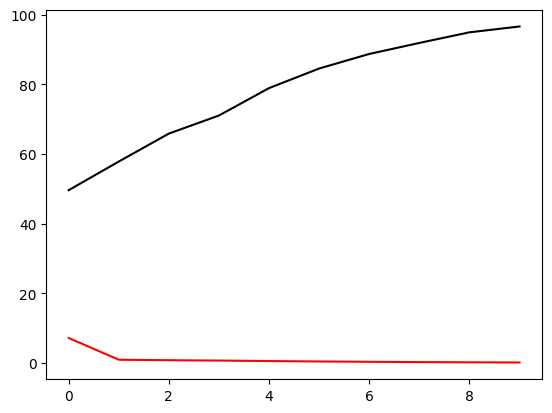

In [32]:
plt.plot(history.history.get('loss'),'r')
plt.plot(np.array(history.history.get('accuracy'))*100,'k')

### Predict test data

In [34]:
prob = model.predict(test_data)
predict_classes=np.argmax(prob,axis=1)
predict_classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


array([2, 0, 2, ..., 3, 2, 3])

### evaluate accuracy and visualize

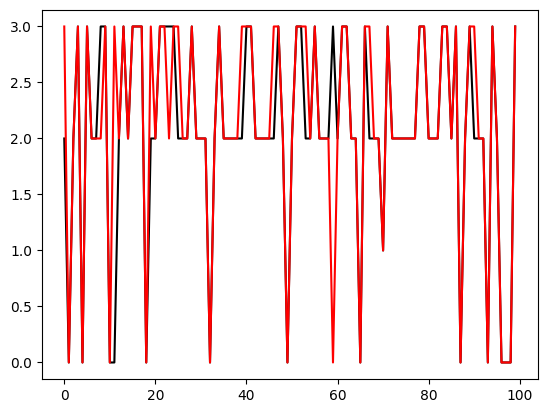

In [36]:
test_lab_idx = np.asarray(test.iloc[:].label)
test_lab_idx

plt.plot(predict_classes[0:100],'k')
plt.plot(test_lab_idx[0:100],'r')

### Hyperparameter tuning

#### Define parameters to tune and the corresponding parameter space
##### (same architecture as before, but with hyperparameter ranges)

In [214]:
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16), # adding filter 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), # adding filter size or kernel size
        activation = 'relu'), # activation function
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 32, max_value = 128, step = 16),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu'), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 32, max_value = 128, step = 16),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 512, step = 32),
        activation='relu'),
        
    # output layer    
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    # compile  model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

### Initiate tuner

In [216]:
tuner = kt.Hyperband(build_model, objective = 'val_accuracy', max_epochs = 10, factor = 3, directory = 'my_dir', project_name = 'AD_class')
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

Reloading Tuner from my_dir\AD_class\tuner0.json


### Run search

In [218]:
# need numpy arrays rather than tensors for tuner
train_images = np.asarray(list(train_ds.map(lambda x, y: x)))
train_labels = np.asarray(list(train_ds.map(lambda x, y: y)))
train_labels = to_categorical(train_labels.astype('int8'))

test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_lab_idx))
test_images = np.asarray(list(test_ds.map(lambda x, y: x)))
test_labels = np.asarray(list(test_ds.map(lambda x, y: y)))
test_labels = to_categorical(test_labels.astype('int8'))

tuner.search(train_images, train_labels, epochs = 20, callbacks = [stop_early],
             validation_data = (test_images, test_labels))

Trial 8 Complete [00h 05m 12s]
val_accuracy: 0.538281261920929

Best val_accuracy So Far: 0.866406261920929
Total elapsed time: 03h 32m 14s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



In [231]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 2 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 96
Filter 2 output dim: 32
Filter 2 output dim: 112

Dense layer units: 320

Learning Rate: 0.001



### Optimal # of epochs

In [237]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs = 50, validation_split = 0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.4693 - loss: 9.2361 - val_accuracy: 0.5674 - val_loss: 0.9077
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.5692 - loss: 0.9375 - val_accuracy: 0.6016 - val_loss: 0.8947
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.6395 - loss: 0.8209 - val_accuracy: 0.6865 - val_loss: 0.7161
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.7090 - loss: 0.6727 - val_accuracy: 0.7021 - val_loss: 0.6778
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.7952 - loss: 0.4986 - val_accuracy: 0.6992 - val_loss: 0.6810
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.8316 - loss: 0.4078 - val_accuracy: 0.7119 - val_loss: 0.6727
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - accuracy: 0.8722 - loss: 0.3232 - val_accuracy: 0.7334 - val_loss: 0.7051
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.8997 - loss: 0

KeyboardInterrupt: 

## Visualize feature maps from

In [273]:
t = test_images[0,:,:,:]
t = np.expand_dims(t, axis = 0)
t.shape

(1, 128, 128, 1)

In [281]:
feature_map = model.predict(t)
feature_map[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([5.0879956e-16, 8.1309663e-16, 1.0000000e+00, 1.6517122e-14],
      dtype=float32)